In [1]:
#Importación de bibliotecas para simulación
import tensorflow as tf
import numpy as np

#Importación de bibliotecas para visualización
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


In [2]:
# Esta función despliega la superficie del agua como una imagen
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))


In [3]:
sess = tf.InteractiveSession()
# Se inicializa la sesión de Tensorflow


In [4]:
def make_kernel(a):
  """Transforma un array 2D en un kernel de convolución"""
  a = np.asarray(a) # Transforma a en un array de Numpy
  a = a.reshape(list(a.shape) + [1,1]) # lo redimensiona
  return tf.constant(a, dtype=1) 

def simple_conv(x, k): # Operación de convolución
  """Una operación de convolución 2D"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Se computa el laplaciano 2D de un array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

In [5]:
N  = 500

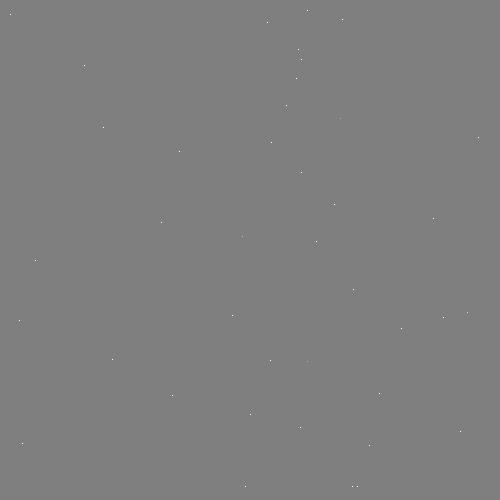

In [6]:
# Condiciones iniciales --> algunas gotas de lluvia caen en un pozo

# Inicializar todo en cero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Algunas gotas de lluvia caen en puntos aleatorios
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])


In [ ]:
import time
# Parámetros:
# eps -- resolución temporal
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Crear variables para el estdo de la simulación
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Reglas de actualización de las PDE's discretizadas
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operación para actualizar el estado
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))


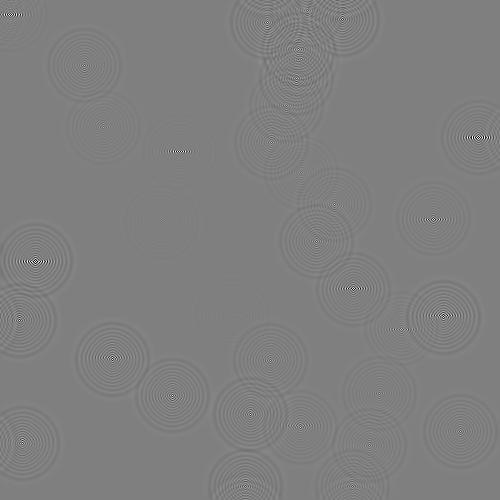

In [ ]:

# Inicializa el estado del sistema con las condiciones iniciales
tf.global_variables_initializer().run()

# Se ejecutan 1000 pasos de la PDE
for i in range(1000):
  # Step de la simulación
  step.run({eps: 0.03, damping: 0.04})
  DisplayArray(U.eval(), rng=[-0.1, 0.1])
  time.sleep(0.1)